In [2]:
import os
import sys
from dotenv import load_dotenv
from uuid import uuid4

from loaders import HuggingFaceBlogLoader, HuggingFaceDocsLoader, ArxivLoader
from data.utils import load_dataframe_from_sheet, get_docs

load_dotenv()

sys.path.append(os.path.abspath(".."))
FIRECRAWL_API_KEY = os.getenv("FIRECRAWL_API_KEY")
GOOGLE_SHEETS_ID = os.getenv("GOOGLE_SHEETS_ID")
GOOGLE_SHEETS_NAME = os.getenv("GOOGLE_SHEETS_NAME")

%load_ext autoreload
%autoreload 2

In [3]:
df = load_dataframe_from_sheet(GOOGLE_SHEETS_ID, GOOGLE_SHEETS_NAME)

In [4]:
hf_blogs_urls = get_docs(df, source="Hugging Face", doc_type="blog", urls_only=True)
hf_blogs_loader = HuggingFaceBlogLoader(firecrawl_api_key=FIRECRAWL_API_KEY, urls=hf_blogs_urls)
hf_blogs_docs = hf_blogs_loader.load()
hf_blogs_docs = hf_blogs_loader.clean(hf_blogs_docs)


Cleaning Hugging Face blogs: 100%|██████████| 5/5 [00:00<00:00, 1543.73it/s]


In [5]:
hf_docs_urls = get_docs(df, source="Hugging Face", doc_type="docs", urls_only=True)
hf_docs_loader = HuggingFaceDocsLoader(firecrawl_api_key=FIRECRAWL_API_KEY, urls=hf_docs_urls)
hf_docs_docs = hf_docs_loader.load()
hf_docs_docs = hf_docs_loader.clean(hf_docs_docs)

Cleaning Hugging Face docs: 100%|██████████| 23/23 [00:00<00:00, 4594.42it/s]


In [6]:
arxiv_urls = get_docs(df, source="arxiv", doc_type="paper", urls_only=True)
arxiv_loader = ArxivLoader(urls=arxiv_urls)
arxiv_docs = arxiv_loader.load()
arxiv_docs = arxiv_loader.clean(arxiv_docs)

Cleaning Arxiv papers: 100%|██████████| 3/3 [00:00<00:00, 667.99it/s]


In [ ]:
all_docs = hf_blogs_docs + hf_docs_docs + arxiv_docs

print(f"Total documents loaded: {len(all_docs)}")

Total documents loaded: 31


In [22]:
from splitter import TrainWiseTokenSplitter
from transformers import AutoTokenizer
# tokenizer = AutoTokenizer.from_pretrained("nomic-ai/modernbert-embed-base")
tokenizer = AutoTokenizer.from_pretrained("jinaai/jina-embeddings-v2-base-code")
text_splitter = TrainWiseTokenSplitter(
    tokenizer = tokenizer,
    tokens_per_chunk = 1200,
    chunk_overlap = 200,
)
chunks = text_splitter.split_docs(all_docs)

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 4a86ad01-e5ab-4dde-bd45-fa4bdb6b8f19)')' thrown while requesting HEAD https://huggingface.co/jinaai/jina-embeddings-v2-base-code/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].


tokenizer_config.json:   0%|          | 0.00/493 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Splitting documents into chunks: 100%|██████████| 31/31 [00:00<00:00, 63.44it/s] 


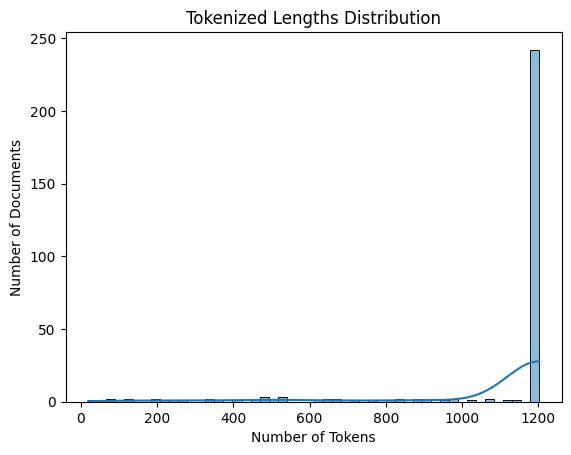

{'max_length': 1202, 'min_length': 19, 'average_length': 1103.736111111111}


In [24]:
from splitter import DocumentsTokensAnalysis
analyzer = DocumentsTokensAnalysis(tokenizer=tokenizer, docs=chunks)
analysis = analyzer.analyze(plot=True)
print(analysis)

In [25]:
from langchain_chroma import Chroma
from endpoints.tei import LocalTEIEmbeddings

hf_embeddings = LocalTEIEmbeddings("http://127.0.0.1:8080")
vector_store = Chroma(
    collection_name="trainwise_data",
    embedding_function=hf_embeddings,
    persist_directory="./chroma_db",
)


In [21]:
uuids = [str(uuid4()) for _ in range(len(chunks))]
vector_store.add_documents(documents=chunks, ids=uuids)

ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=8080): Max retries exceeded with url: /v1/embeddings (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x124006520>: Failed to establish a new connection: [Errno 61] Connection refused'))